In [1]:
#!unzip dank_data-master.zip
#!pip install tensorflow_addons
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [2]:
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten,Embedding,LSTM,concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
import logging
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
training='/content/dank_data-master/data/training/*'
test='/content/dank_data-master/data/test/*'
validation='/content/dank_data-master/data/validation/*'

In [4]:
training = glob.glob(training)
test = glob.glob(test)
validation = glob.glob(validation)

In [5]:
final_dank=pd.read_csv('/content/dank_data-master/data/final_dank.csv')
train_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in training]
validation_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in validation]
test_labels = [fn.split('/')[-1].split('.')[0].strip() for fn in test]

In [6]:
for labels in train_labels:
    if labels==train_labels[0]:
        train_data =final_dank[final_dank['id']==labels]
    else :
        train_data =train_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in validation_labels:
    if labels==validation_labels[0]:
        val_data =final_dank[final_dank['id']==labels]
    else :
        val_data =val_data.append(final_dank[final_dank['id']==labels],sort=False)
for labels in test_labels:
    if labels==test_labels[0]:
        test_data =final_dank[final_dank['id']==labels]
    else :
        test_data =test_data.append(final_dank[final_dank['id']==labels],sort=False)
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)
train_data.head(5)

(3405, 68)
(1719, 68)
(1688, 68)


,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
27060,48660,50940.0,50940.0,FreezeY7,[],"['gamer', 'xbox', 'xbox', 'playstat']",1.584235e+09,0.0,fit80n,False,https://i.redd.it/5cpizrgflqm41.jpg,r/memes,9552902.0,136.0,default,140.0,Gamers unite,4430.0,/r/memes/comments/fit80n/gamers_unite/,2020-03-14 20:10:36,4.0,4.637334e-04,1.0,61.0,0.49,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29398,52076,54537.0,54537.0,sraff57,[],"['wait', 'metowißi', 'stick', 'know', 'rule', ...",1.584217e+09,0.0,fios8u,False,https://i.redd.it/t23cfasb5pm41.jpg,r/memes,9552912.0,140.0,https://a.thumbs.redditmedia.com/I-6emwPP50CaM...,140.0,"Wait, what are you doing?!?!",2085.0,/r/memes/comments/fios8u/wait_what_are_you_doing/,2020-03-14 15:18:34,3.0,2.182581e-04,1.0,100.0,0.43,6.0,117.131659,135.557786,9.252348,161.599832,112.027603,161.619876,1.452131,0.0,0.0,1.479624,0.0,3.574983,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.306579,3.693118,0.0,0.0,0.0,0.0,59.748012,0.0,0.0,0.0,0.0,0.000000,0.014749,0.565066,0.060382,0.035474,web_site,book_jacket,bulletproof_vest
53584,96576,1088.0,32741.0,sdrisc2692,[],"['reddit', 'mobil', 'reddit', 'mobil', 'mind']",1.584914e+09,0.0,fn80tk,False,https://i.redd.it/647g7iqfpao41.jpg,r/memes,10674286.0,140.0,https://b.thumbs.redditmedia.com/Zh-ilteB7oXYR...,140.0,To sum up reddit mobile:,20.0,/r/memes/comments/fn80tk/to_sum_up_reddit_mobile/,2020-03-22 16:52:49,3.0,1.873662e-06,0.0,49.0,0.45,5.0,114.411775,150.795775,15.035978,161.424079,116.582826,162.304915,2.387553,0.0,0.0,6.700281,0.0,0.001293,1.151742,0.000000,0.065962,0.230866,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.142689,0.000000,0.0,0.0,0.0,0.0,27.123174,0.0,0.0,0.0,0.0,0.230866,0.015520,0.680993,0.067452,0.050404,web_site,Granny_Smith,banana
27044,48639,50917.0,50917.0,meeeeeeeph,[],"['meme', 'youtub', 'break', 'real', 'genuin', ...",1.584235e+09,0.0,fit9g6,False,https://i.redd.it/dcz9h7bylqm41.jpg,r/memes,9552902.0,140.0,default,140.0,This isn’t a meme but this youtuber just broke...,1.0,/r/memes/comments/fit9g6/this_isnt_a_meme_but_...,2020-03-14 20:13:34,4.0,1.046802e-07,0.0,451.0,0.70,26.0,157.262803,150.143991,81.755107,154.083191,43.572516,167.579094,8.594830,0.0,0.0,1.996332,0.0,0.000555,0.143401,0.372659,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.006846,0.0,1.995962,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.123341,0.312252,0.043995,0.039401,comic_book,refrigerator,can_opener
14024,29120,30519.0,30519.0,pronoob-_-,[],"['corona', 'ᕗfinal', 'report', 'test', 'dengu'...",1.584364e+09,0.0,fjkmt5,False,https://i.redd.it/xqrdd00s91n41.jpg,r/memes,9552837.0,140.0,https://b.thumbs.redditmedia.com/18UmvLAPuBZWb...,140.0,No Corona for me ᕙ( ͡◉ ͜ ʖ ͡◉)ᕗ,5753.0,/r/memes/comments/fjkmt5/no_corona_for_me_ᕙ_ʖ_ᕗ/,2020-03-16 08:04:56,1.0,6.022295e-04,1.0,290.0,0.44,21.0,87.709108,92.152124,68.006554,97.757133,62.503956,103.276077,2.418405,0.0,0.0,1.275989,0.0,0.008372,1.187321,0.125201,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.162003,0.001142,0.0,0.0,0.0,0.0,0.144990,0.0,0.0,0.0,0.0,0.000000,0.641229,0.545186,0.064092,0.055442,lumbermill,thresher,horse_cart


In [7]:
def file_extension(x):
      return x+".jpg"
train_data['id'] = train_data['id'].apply(file_extension)
val_data['id'] = val_data['id'].apply(file_extension)
test_data['id'] = test_data['id'].apply(file_extension)

In [8]:
def numeric_to_string(x):
    if (x==1.0):
        return 'Not_dank'
    elif (x==0.0):
        return 'Dank'
train_data['dank_level_new'] = train_data['dank_level'].apply(numeric_to_string)
val_data['dank_level_new'] = val_data['dank_level'].apply(numeric_to_string)
test_data['dank_level_new'] = test_data['dank_level'].apply(numeric_to_string)

In [9]:
  logger = logging.getLogger()
  logger.disabled = False  
  train_datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
                                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                    horizontal_flip=True, fill_mode='nearest')
  train_generator = train_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              subset="training",
              batch_size=30,
              seed=42,
              class_mode="binary",
              target_size= (512,512))
  predict_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  train_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=train_data,
              directory="/content/dank_data-master/data/training/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              class_mode="binary",
              shuffle=False,
              target_size= (512,512))
  validation_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=val_data,
              directory="/content/dank_data-master/data/validation/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (512,512))
  test_prediction_generator = predict_datagen.flow_from_dataframe(
              dataframe=test_data,
              directory="/content/dank_data-master/data/test/",
              x_col="id",
              y_col="dank_level_new",
              batch_size=30,
              seed=42,
              shuffle=False,
              class_mode="binary",
              target_size= (512,512))

Found 3405 validated image filenames belonging to 2 classes.
Found 3405 validated image filenames belonging to 2 classes.
Found 1688 validated image filenames belonging to 2 classes.
Found 1719 validated image filenames belonging to 2 classes.


In [10]:
IMAGE_SIZE = [512,512]
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
for layer in vgg16.layers[:11]:
    layer.trainable = False

In [12]:
#Flatten
flatten = Flatten(data_format='channels_last',name='Flatten')(vgg16.output)

#FC layer
FC1 = Dense(units=512,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)
x = Dropout(0.3)(FC1)
#FC layer
FC2 = Dense(units=512,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(x)
x = Dropout(0.3)(FC2)

#output layer
Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(x)

model = Model(inputs=vgg16.input, outputs=Out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [13]:
def scheduler(epoch,lr):
    if((epoch+1)%3==0):
        lr=lr*0.95
        return lr
    else:
        return lr

In [14]:

filepath="model_save_new/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=3,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=3, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [16]:
history=model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=2,validation_data=test_prediction_generator,validation_steps=len(test_prediction_generator),use_multiprocessing=False,workers=12,callbacks=[lrschedule,checkpoint,reduce_lr])

Epoch 1/2

Epoch 00001: LearningRateScheduler reducing learning rate to 9.02499959920533e-06.
114/114 [==============================] - 297s 2s/step - loss: 0.6772 - accuracy: 0.5715 - precision: 0.5732 - recall: 0.5128 - f1_score: 0.6605 - val_loss: 0.6859 - val_accuracy: 0.5445 - val_precision: 0.5508 - val_recall: 0.3129 - val_f1_score: 0.6518
Epoch 2/2

Epoch 00002: LearningRateScheduler reducing learning rate to 9.02499959920533e-06.
114/114 [==============================] - 296s 2s/step - loss: 0.6768 - accuracy: 0.5783 - precision: 0.5770 - recall: 0.5420 - f1_score: 0.6605 - val_loss: 0.6808 - val_accuracy: 0.5608 - val_precision: 0.5556 - val_recall: 0.4573 - val_f1_score: 0.6518


In [18]:
model_checkpoint =  Model(inputs=vgg16.input, outputs=FC2)
model_checkpoint.save('bestmodel_vgg16_lstm.h5')
new_model = tf.keras.models.load_model('bestmodel_vgg16_lstm.h5')

In [19]:
predict_train=new_model.predict_generator(train_prediction_generator,steps=len(train_prediction_generator),workers=12)
predict_test=new_model.predict_generator(test_prediction_generator,steps=len(test_prediction_generator),workers=12)
predict_train.shape

(3405, 512)

In [20]:
train_data_words=train_data['processed_words'].values
validation_words=val_data['processed_words'].values
test_data_words=test_data['processed_words'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_words)
vocab_size=len(tokenizer.word_index)
encoded_Xtrain_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in train_data_words]
encoded_validation_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in validation_words]
encoded_Xtest_words = [tf.keras.preprocessing.text.one_hot(d, vocab_size,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') for d in test_data_words]

padded_Xtrain_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtrain_words, maxlen=20, padding='post')
padded_Xvalidation_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_validation_words, maxlen=20, padding='post')
padded_Xtest_words = tf.keras.preprocessing.sequence.pad_sequences(encoded_Xtest_words, maxlen=20, padding='post')

In [21]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['subreddit'].values)
subreddit_train=labelencoder.transform(train_data['subreddit'].values).reshape(-1,1)
subreddit_validation=labelencoder.transform(val_data['subreddit'].values).reshape(-1,1)
subreddit_test=labelencoder.transform(test_data['subreddit'].values).reshape(-1, 1)

print(subreddit_train.shape)
print(subreddit_test.shape)
print(subreddit_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [24]:
labelencoder = LabelEncoder()
labelencoder.fit(train_data['is_nsfw'].values)
is_nsfw_train=labelencoder.transform(train_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_validation=labelencoder.transform(val_data['is_nsfw'].values).reshape(-1,1)
is_nsfw_test=labelencoder.transform(test_data['is_nsfw'].values).reshape(-1,1)

print(is_nsfw_train.shape)
print(is_nsfw_test.shape)
print(is_nsfw_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [25]:
time_of_day_train=(train_data['time_of_day'].values).reshape(-1,1)
time_of_day_validation=(val_data['time_of_day'].values).reshape(-1,1)
time_of_day_test=(test_data['time_of_day'].values).reshape(-1,1)

print(time_of_day_train.shape)
print(time_of_day_validation.shape)
print(time_of_day_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [26]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['created_utc'].values.reshape(-1, 1))

created_utc_train=scaler.transform(train_data['created_utc'].values.reshape(-1, 1))
created_utc_validation=scaler.transform(val_data['created_utc'].values.reshape(-1, 1))
created_utc_test=scaler.transform(test_data['created_utc'].values.reshape(-1, 1))

print(created_utc_train.shape)
print(created_utc_test.shape)
print(created_utc_validation.shape)

(3405, 1)
(1719, 1)
(1688, 1)


In [27]:
scaler = StandardScaler()
scaler=scaler.fit(train_data['subscribers'].values.reshape(-1, 1))

subscribers_train=scaler.transform(train_data['subscribers'].values.reshape(-1, 1))
subscribers_validation=scaler.transform(val_data['subscribers'].values.reshape(-1, 1))
subscribers_test=scaler.transform(test_data['subscribers'].values.reshape(-1, 1))

print(subscribers_train.shape)
print(subscribers_validation.shape)
print(subscribers_test.shape)

(3405, 1)
(1688, 1)
(1719, 1)


In [28]:

#words  embeding layer
words =Input(shape=(20,),name="words")
embeding=Embedding(vocab_size+1,300,weights=[embedding_matrix],input_length=20,trainable=False)(words)
lstm_layer=LSTM(500)(embeding)
flatten1 = Flatten(data_format='channels_last')(lstm_layer)

image_predicted =Input(shape=(predict_train.shape[1],),name="image_predicted")
flatten2= Flatten(data_format='channels_last')(image_predicted)

#categore_data
subreddit_train_layer =Input(shape=(subreddit_train.shape[1],),name="subreddit_train_layer")
flatten3= Flatten(data_format='channels_last')(subreddit_train_layer)
###
is_nsfw_train_layer =Input(shape=(is_nsfw_train.shape[1],),name="is_nsfw_train_layer")
flatten4 = Flatten(data_format='channels_last')(is_nsfw_train_layer)
####
time_of_day_train_layer =Input(shape=(time_of_day_train.shape[1],),name="time_of_day_train_layer")
flatten5 = Flatten(data_format='channels_last')(time_of_day_train_layer)

#numeric_data
created_utc_train_layer =Input(shape=(created_utc_train.shape[1],),name="created_utc_train_layer")
created_utc_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(created_utc_train_layer)

#numeric_data
subscribers_train_layer =Input(shape=(subscribers_train.shape[1],),name="subscribers_train_layer")
subscribers_dence = Dense(units=3,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(subscribers_train_layer)

#concat layer
concatenated = concatenate([subscribers_train_layer,created_utc_dence,flatten5,flatten4,flatten3,flatten2,flatten1],axis = -1)

dense_layer1 = Dense(units=420,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(concatenated)
dropout1=Dropout(0.3)(dense_layer1)

dense_layer2 = Dense(units=210,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout1)
dropout2=Dropout(0.3)(dense_layer2)

dense_layer3 = Dense(units=105,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout2)
dropout3=Dropout(0.3)(dense_layer3)

dense_layer4 = Dense(units=60,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout3)
dropout4=Dropout(0.3)(dense_layer4)

dense_layer5 = Dense(units=30,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout4)
dropout5=Dropout(0.3)(dense_layer5)

dense_layer6 = Dense(units=15,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(dropout5)


Out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(dense_layer6)

model = Model(inputs=[image_predicted,words,subreddit_train_layer,is_nsfw_train_layer,time_of_day_train_layer,created_utc_train_layer,subscribers_train_layer],outputs=Out)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 300)      2712000     words[0][0]                      
__________________________________________________________________________________________________
created_utc_train_layer (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
time_of_day_train_layer (InputL [(None, 1)]          0                                            
____________________________________________________________________________________________

In [29]:
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',save_best_only=True, mode='auto')



lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0.1)

#stop the training if your validation accuracy is not increased in last 2 epochs.
early_stop= EarlyStopping(monitor='val_accuracy', patience=2,verbose=1) 

#If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#learning rate by 10%
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9,
                              patience=0, min_lr=0.001,verbose=1)

model.compile(
  loss='binary_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), 
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=1)]
)


In [30]:
y_train =train_data['dank_level'].values
y_test =test_data['dank_level'].values
y_train.shape

(3405,)

In [32]:
history=model.fit({"image_predicted":predict_train,"words":padded_Xtrain_words,"subreddit_train_layer":subreddit_train,"is_nsfw_train_layer":is_nsfw_train,"time_of_day_train_layer":time_of_day_train,
                    "created_utc_train_layer":created_utc_train,"subscribers_train_layer":subscribers_train},
                     y_train,epochs=100,batch_size=30,
                  validation_data=({"image_predicted":predict_test,"words":padded_Xtest_words,"subreddit_train_layer":subreddit_test,"is_nsfw_train_layer":is_nsfw_test,"time_of_day_train_layer":time_of_day_test,
                    "created_utc_train_layer":created_utc_test,"subscribers_train_layer":subscribers_test},y_test),callbacks=[lrschedule,checkpoint,reduce_lr])


Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1.8402588466415182e-06.
114/114 [==============================] - 2s 14ms/step - loss: 0.6751 - accuracy: 0.5680 - precision_1: 0.5695 - recall_1: 0.5074 - f1_score: 0.6605 - val_loss: 0.6780 - val_accuracy: 0.5707 - val_precision_1: 0.5658 - val_recall_1: 0.4813 - val_f1_score: 0.6518
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8402588466415182e-06.
114/114 [==============================] - 1s 13ms/step - loss: 0.6731 - accuracy: 0.5824 - precision_1: 0.5848 - recall_1: 0.5277 - f1_score: 0.6605 - val_loss: 0.6779 - val_accuracy: 0.5713 - val_precision_1: 0.5664 - val_recall_1: 0.4826 - val_f1_score: 0.6518
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 1.7482459043094422e-06.
114/114 [==============================] - 2s 13ms/step - loss: 0.6741 - accuracy: 0.5794 - precision_1: 0.5796 - recall_1: 0.5354 - f1_score: 0.6605 - val_loss: 0.6778 - val_acc

In [33]:
model.save('bestmodel_vgg16_lstm_1.h5')
new_model = tf.keras.models.load_model('bestmodel_vgg16_lstm_1.h5')

In [34]:
test_prediction=model.predict([predict_test,padded_Xtest_words,subreddit_test,is_nsfw_test,time_of_day_test,
                    created_utc_test,subscribers_test])
test_prediction=((test_prediction > 0.5)+0).ravel() 
print(test_prediction.shape)
y_test =tf.keras.utils.to_categorical(test_data['dank_level'].values,2)
y_test=np.argmax(y_test,axis=-1)
y_test.shape

(1719,)


(1719,)

Test accuracy_score 0.5799883653286795
Test F1_score 0.5441919191919193
Test confusion matrix


Text(0.5, 15.0, 'Predicted label')

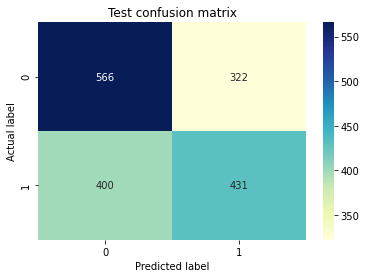

In [35]:
accuracy=accuracy_score(y_test,test_prediction)
print("Test accuracy_score",accuracy)
f1_test_score=f1_score(y_test,test_prediction)
print("Test F1_score",f1_test_score)
print("Test confusion matrix")
cnf_matrix2=confusion_matrix(y_test,test_prediction)
p = sns.heatmap(pd.DataFrame(cnf_matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Test confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

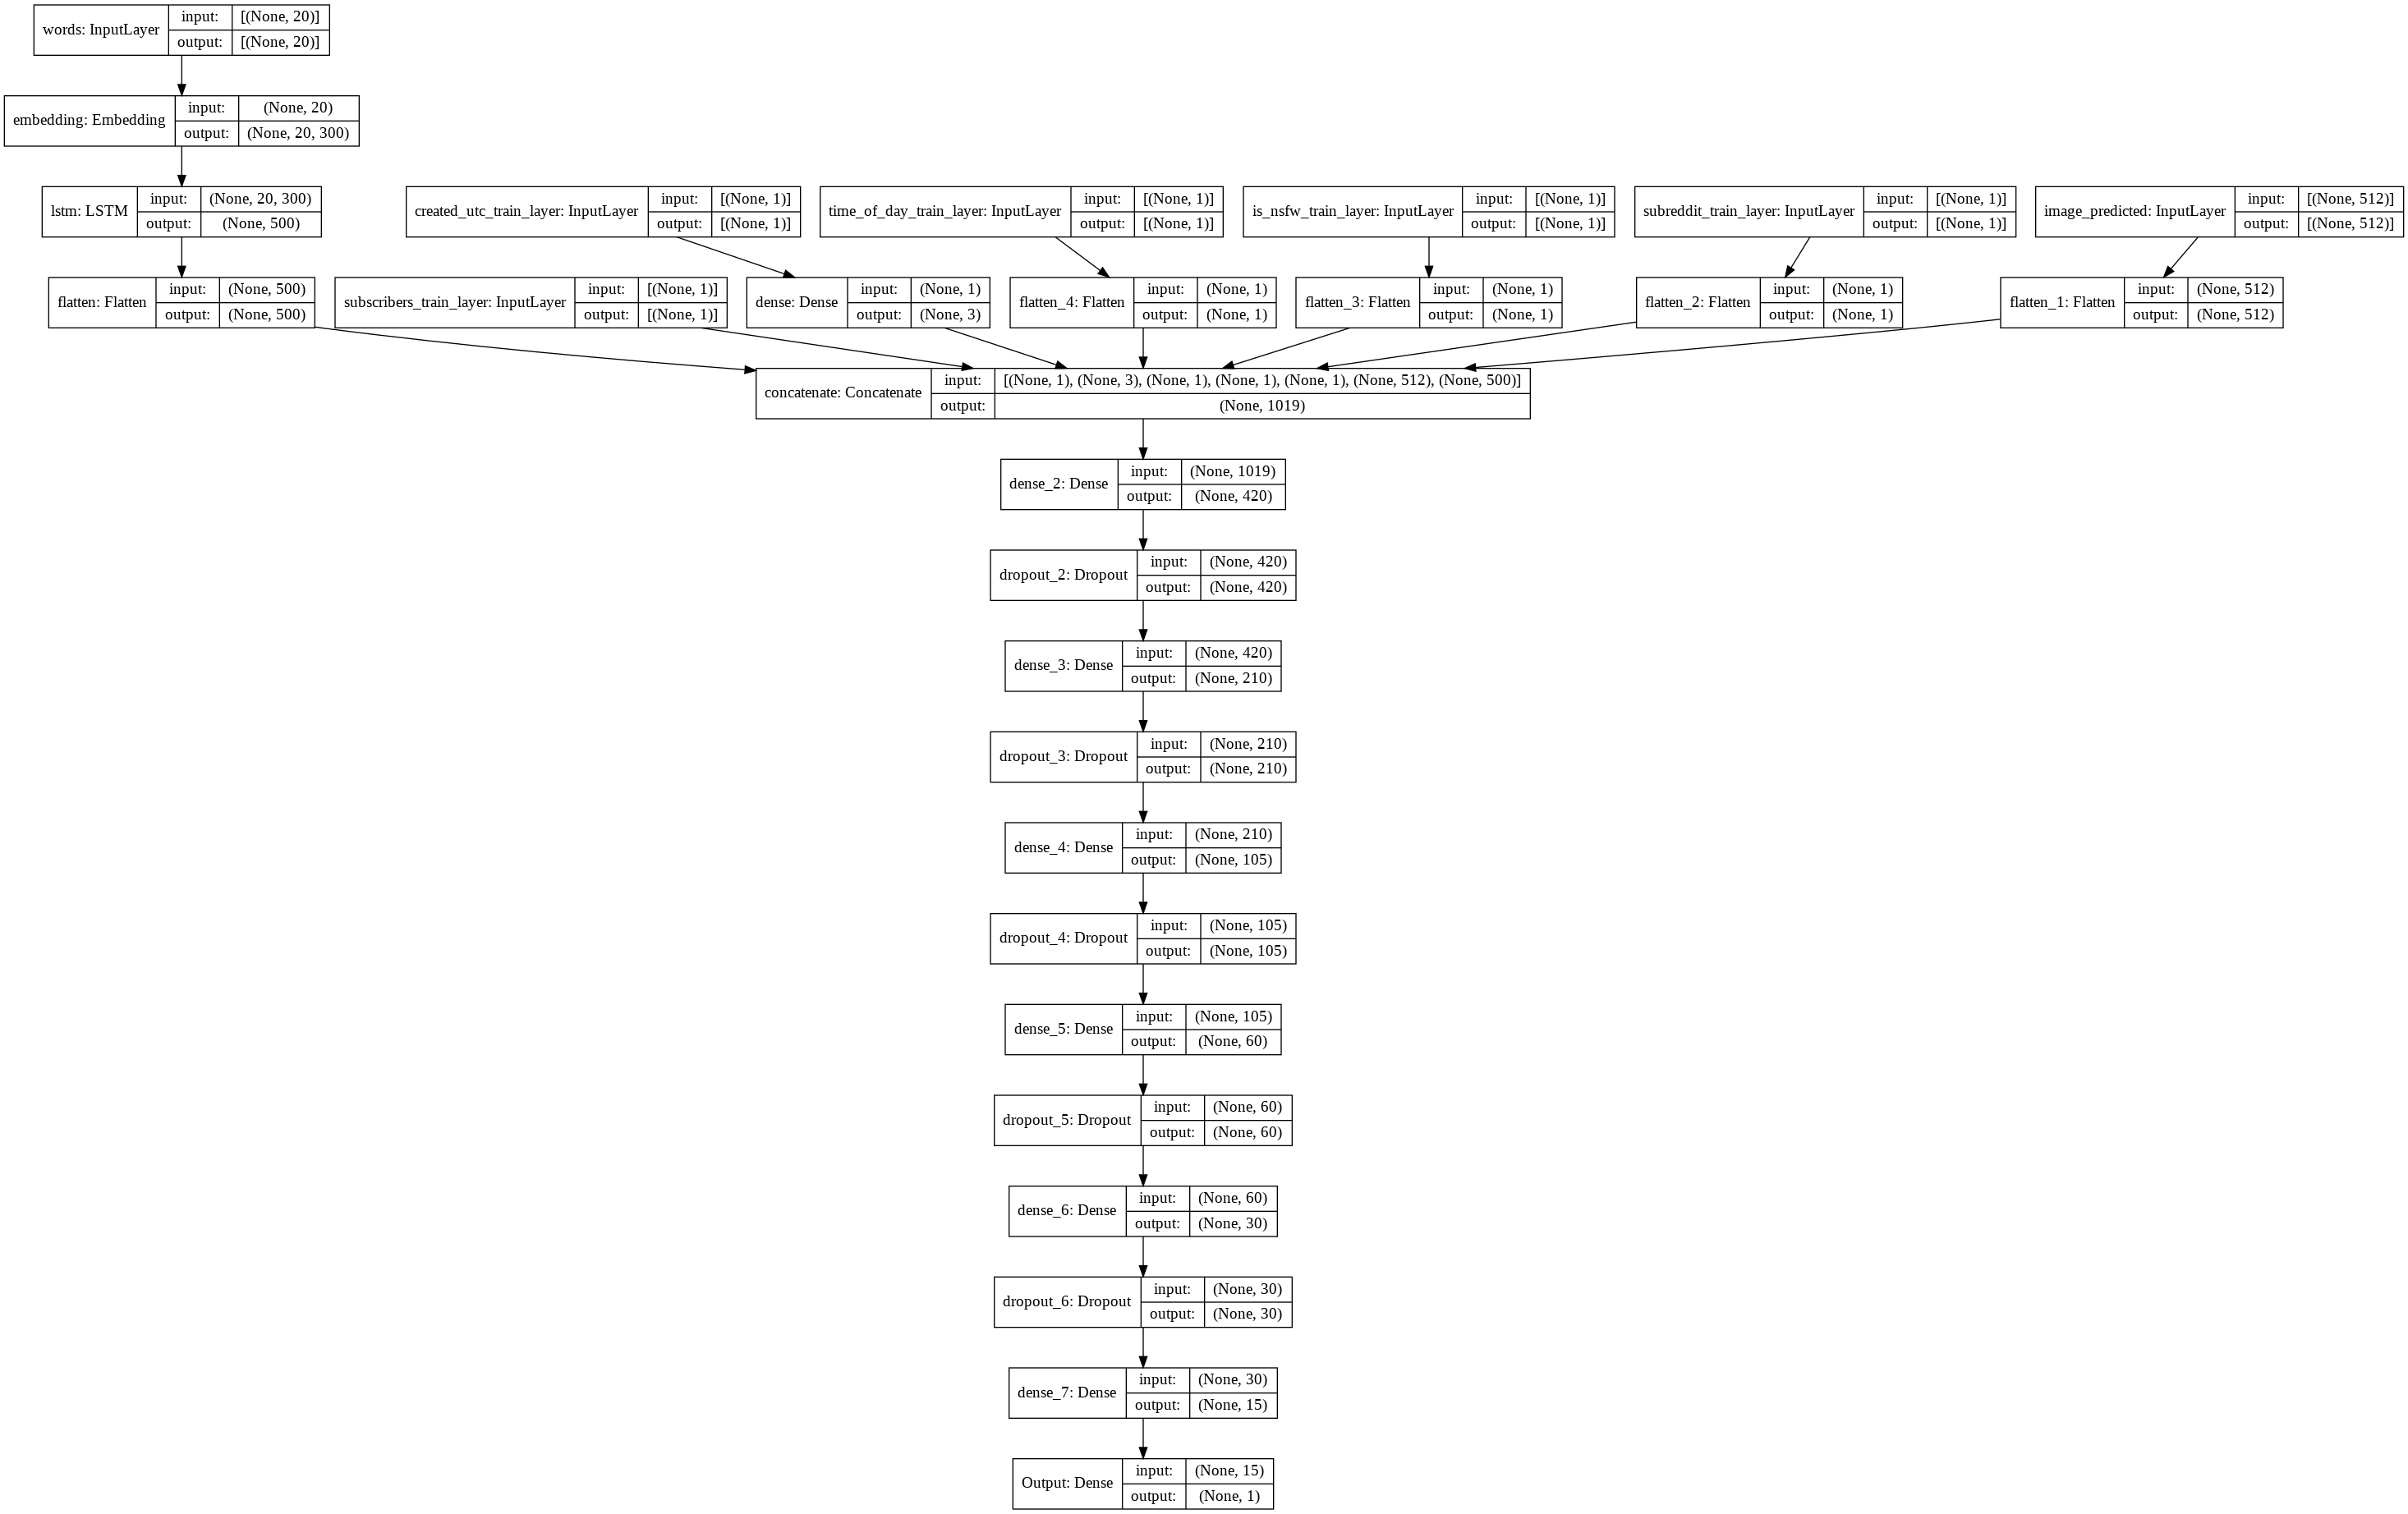

In [36]:
file = '/content/model_1.png'
tf.keras.utils.plot_model(model,to_file=file, show_shapes=True)